In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
#Data Manipulation

from scipy.sparse import csr_matrix
from collections import Counter

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import string

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet
from nltk.corpus import stopwords

nltk.download('punkt')

import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpor

In [2]:
dir = '../input/airline-dataset/'

df = pd.read_csv(dir+'AirlineTweets.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
X = df['text']
y = df['airline_sentiment']

In [6]:
y.value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [7]:
#Split the data
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.18, random_state=42, stratify = y_tr)

# Reset indexes
X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)
X_tr = X_tr.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_tr = y_tr.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [8]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(10204,) (2240,) (2196,) (10204,) (2240,) (2196,)


## First model: CountVectorizer

In [9]:
featurizer_cv = CountVectorizer(decode_error='ignore', lowercase = True)
Xtrain = featurizer_cv.fit_transform(X_train)
Xval = featurizer_cv.transform(X_val)

clr = LogisticRegression(max_iter=500)
clr.fit(Xtrain, y_train)

y_predict = clr.predict(Xval)

In [10]:
print(f'Accuracy: {accuracy_score(y_val, y_predict)}')
print(f'Classes: {clr.classes_}')
print(f'Precision: {precision_score(y_val, y_predict,average=None)}')
print(f'Recall: {recall_score(y_val, y_predict,average=None)}')
print(f'F1 Score: {f1_score(y_val, y_predict,average=None)}')

Accuracy: 0.8044642857142857
Classes: ['negative' 'neutral' 'positive']
Precision: [0.86373021 0.63655031 0.79      ]
Recall: [0.89387464 0.65400844 0.65469613]
F1 Score: [0.87854393 0.64516129 0.71601208]


We did pretty well with the "negative" emotion, but not so great with the others. Lets try other types of featurizers to see if our performance increases.

In [11]:
featurizer_cv2 = CountVectorizer(decode_error='ignore', lowercase = True, stop_words='english')
Xtrain = featurizer_cv2.fit_transform(X_train)
Xval = featurizer_cv2.transform(X_val)

clr2 = LogisticRegression(max_iter=500)
clr2.fit(Xtrain, y_train)

y_predict = clr2.predict(Xval)

In [12]:
print(f'Accuracy: {accuracy_score(y_val, y_predict)}')
print(f'Classes: {clr.classes_}')
print(f'Precision: {precision_score(y_val, y_predict,average=None)}')
print(f'Recall: {recall_score(y_val, y_predict,average=None)}')
print(f'F1 Score: {f1_score(y_val, y_predict,average=None)}')

Accuracy: 0.7758928571428572
Classes: ['negative' 'neutral' 'positive']
Precision: [0.83975659 0.5941704  0.73333333]
Recall: [0.88461538 0.55907173 0.63812155]
F1 Score: [0.8616025  0.57608696 0.68242245]


Removing stop_words decreased our overall performance, so we will ignore this technique. Lets see what is the impact of lemmatizing the document

In [13]:
## Lemmatizing the input
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Função de lematização
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)

X_train_lemmatized = [lemmatize_text(text) for text in X_train]
X_val_lemmatized = [lemmatize_text(text) for text in X_val]

In [14]:
# Criação do CountVectorizer e transformação dos dados
featurizer_cv3 = CountVectorizer(decode_error='ignore', lowercase=True)
Xtrain = featurizer_cv3.fit_transform(X_train_lemmatized)
Xval = featurizer_cv3.transform(X_val_lemmatized)

clr3 = LogisticRegression(max_iter=500)
clr3.fit(Xtrain, y_train)

y_predict = clr3.predict(Xval)

In [15]:
print(f'Accuracy: {accuracy_score(y_val, y_predict)}')
print(f'Classes: {clr.classes_}')
print(f'Precision: {precision_score(y_val, y_predict,average=None)}')
print(f'Recall: {recall_score(y_val, y_predict,average=None)}')
print(f'F1 Score: {f1_score(y_val, y_predict,average=None)}')

Accuracy: 0.7977678571428571
Classes: ['negative' 'neutral' 'positive']
Precision: [0.85490463 0.63829787 0.76821192]
Recall: [0.89387464 0.63291139 0.64088398]
F1 Score: [0.87395543 0.63559322 0.69879518]


We had a simmilar result from the first model. Let's try to use TF-IDF now and see if we can get a better result

## Second Model: TfIdf Vectorizer

In [16]:
featurizer_cv4 = TfidfVectorizer(decode_error='ignore')
Xtrain = featurizer_cv4.fit_transform(X_train)
Xval = featurizer_cv4.transform(X_val)

clr4 = LogisticRegression(max_iter=500)
clr4.fit(Xtrain, y_train)

y_predict = clr4.predict(Xval)

In [17]:
print(f'Accuracy: {accuracy_score(y_val, y_predict)}')
print(f'Classes: {clr.classes_}')
print(f'Precision: {precision_score(y_val, y_predict,average=None)}')
print(f'Recall: {recall_score(y_val, y_predict,average=None)}')
print(f'F1 Score: {f1_score(y_val, y_predict,average=None)}')

Accuracy: 0.803125
Classes: ['negative' 'neutral' 'positive']
Precision: [0.81902409 0.71117166 0.83464567]
Recall: [0.94444444 0.55063291 0.58563536]
F1 Score: [0.87727423 0.62068966 0.68831169]


In [18]:
featurizer_cv5 = TfidfVectorizer(decode_error='ignore')
Xtrain = featurizer_cv5.fit_transform(X_train_lemmatized)
Xval = featurizer_cv5.transform(X_val_lemmatized)

clr5 = LogisticRegression(max_iter=500)
clr5.fit(Xtrain, y_train)

y_predict = clr5.predict(Xval)

In [19]:
print(f'Accuracy: {accuracy_score(y_val, y_predict)}')
print(f'Classes: {clr.classes_}')
print(f'Precision: {precision_score(y_val, y_predict,average=None)}')
print(f'Recall: {recall_score(y_val, y_predict,average=None)}')
print(f'F1 Score: {f1_score(y_val, y_predict,average=None)}')

Accuracy: 0.8040178571428571
Classes: ['negative' 'neutral' 'positive']
Precision: [0.82327318 0.70157068 0.83665339]
Recall: [0.94230769 0.56540084 0.5801105 ]
F1 Score: [0.87877781 0.62616822 0.68515498]


# Conclusions

- There is no clear improvement using stop-words, lemmatizing or stop-words in this case
- The simple count method shown a better results than Tdifdvectorizer

## Test sample evaluation

In [20]:
featurizer_final = CountVectorizer(decode_error='ignore', lowercase = True)

Xtrain = featurizer_final.fit_transform(X_tr)
Xtest = featurizer_final.transform(X_test)

clr_final = LogisticRegression(max_iter=500)
clr_final.fit(Xtrain, y_tr)

y_predict = clr_final.predict(Xtest)

In [21]:
print(f'Accuracy: {accuracy_score(y_test, y_predict)}')
print(f'Classes: {clr_final.classes_}')
print(f'Precision: {precision_score(y_test, y_predict,average=None)}')
print(f'Recall: {recall_score(y_test, y_predict,average=None)}')
print(f'F1 Score: {f1_score(y_test, y_predict,average=None)}')

Accuracy: 0.8000910746812386
Classes: ['negative' 'neutral' 'positive']
Precision: [0.86284115 0.6349892  0.75657895]
Recall: [0.89542484 0.63225806 0.64971751]
F1 Score: [0.87883108 0.63362069 0.69908815]


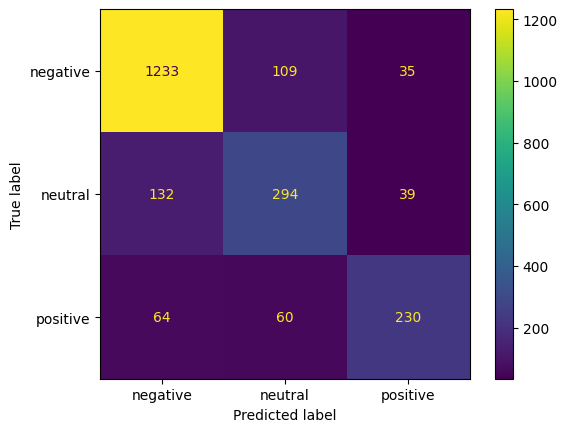

In [22]:
#Lets create a confusion matrix

# Calculate the values for each quadrant in the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predict)

# Create the confusion matrix as a visualization
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clr_final.classes_)

# Display the confusion matrix
disp.plot()

## Highlights
1. The model had a pretty decent accuracy for the negative tweets.
2. The model had difficulties finding all neutral (and labbeling some of them as negative).
3. The model had difficulties finding all positive (and labbeling some of them as negative).
4. Our model seens to have some bias to think that the tweet is has a negative sentiment.

In [23]:
#Lets train the data dropping the neutral tweets
featurizer_final = CountVectorizer(decode_error='ignore', lowercase = True)

Xtrain = featurizer_final.fit_transform(X_tr[y_tr!='neutral'])
Xtest = featurizer_final.transform(X_test[y_test!='neutral'])

clr_final = LogisticRegression(max_iter=500)
clr_final.fit(Xtrain, y_tr[y_tr!='neutral'])

y_predict = clr_final.predict(Xtest)

In [24]:
print(f'Accuracy: {accuracy_score(y_test[y_test!="neutral"], y_predict)}')
print(f'Precision: {precision_score(y_test[y_test!="neutral"], y_predict,average=None)}')
print(f'Recall: {recall_score(y_test[y_test!="neutral"], y_predict,average=None)}')
print(f'F1 Score: {f1_score(y_test[y_test!="neutral"], y_predict,average=None)}')

Accuracy: 0.9260543038705951
Precision: [0.93824561 0.86928105]
Recall: [0.97095134 0.75141243]
F1 Score: [0.95431834 0.80606061]


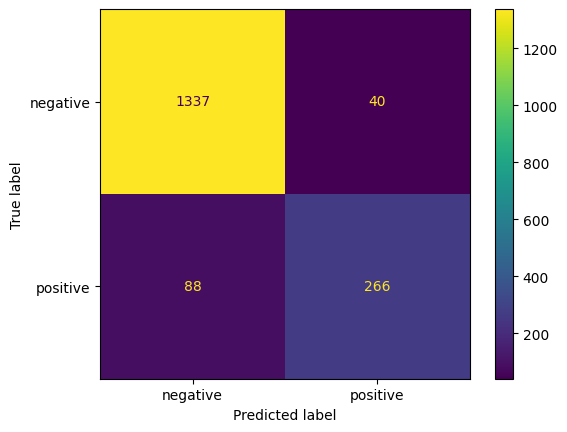

In [25]:
#Lets create a confusion matrix

# Calculate the values for each quadrant in the confusion matrix
cm = metrics.confusion_matrix(y_test[y_test!="neutral"], y_predict)

# Create the confusion matrix as a visualization
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clr_final.classes_)

# Display the confusion matrix
disp.plot()

Our model performed better after dropping the neutral tweets. Maybe, neutral tweets inserts more noise to the data than context. 

## Lets check the value of the coefficients

In [26]:
word2idx = featurizer_final.vocabulary_

count = 0
for item, value in word2idx.items():
    print(item, value)
    count+=1
    if count>8:
        break

united 10707
my 7086
son 9471
left 6328
his 5386
tablet 9935
on 7497
plane 7930
am 1590


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

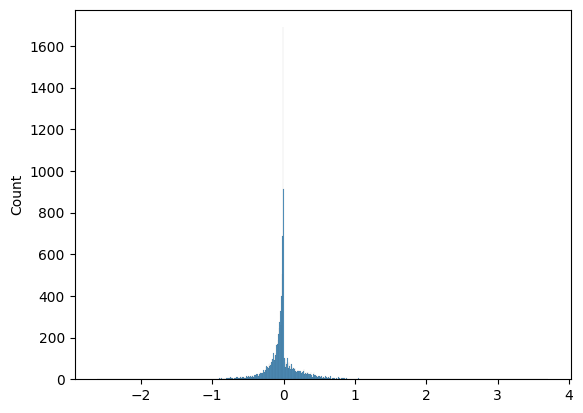

In [27]:
coef = clr_final.coef_

sns.histplot(coef[0])

The great majority of values are centered mean zero, with more neggative values than positives. Lets see which words are associated with the greatest values of coefficients.

In [28]:
threshold = 1

print("Positive Words")
for word, index in word2idx.items():
    weight = coef[0][index]
    if weight > threshold:
        print(word, weight)

Positive Words
thank 3.7045916138533537
definitely 1.4807880983330126
favorite 1.2234327277469268
thanks 2.8499029465803227
good 1.515823902295053
lovely 1.0470684258928968
great 2.6080215999486747
rock 1.412908167465153
thx 1.9029974370806424
follow 1.0476302592176283
made 1.1439972526454432
best 2.0106749300402385
excellent 2.2156267327287567
virginamerica 1.048989535198379
deserves 1.2133318906352013
worries 2.836013260514329
exceptional 1.381817189355088
wonderful 2.1356618536893595
awesome 2.5855500202281507
warm 1.1131689120613264
excited 1.4774403356537016
pleasure 1.3536937391544155
love 2.487718167436153
cool 1.7154404379103128
nice 1.0795438245511477
wish 1.1666348467185512
refunded 1.191981898696736
appreciate 2.0401740035208373
thankful 1.8103724757109345
happy 1.2663471624874827
few 1.2536748913820586
exactly 1.0285602771135858
onboard 1.0697378331861676
type 1.6121869300068548
cancun 1.0472275423237414
visit 1.151739703609711
amazing 2.395348846103051
appreciated 1.011159

In [29]:
print("Negative Words")
for word, index in word2idx.items():

    weight = coef[0][index]
    
    if weight < -threshold:
        print(word, weight)

Negative Words
not -1.5273128487112726
cancelled -1.1841661185328423
delayed -1.8831280107613881
why -1.234701169795087
passengers -1.1929979731416183
hours -1.7204295685330955
hold -1.736474150237618
days -1.1405240449263319
no -1.4534964022120958
asap -1.169433749971158
account -1.03987944004185
doesn -1.4285072759883974
lost -1.1074549172292425
terrible -1.4511683975872276
website -1.382883288504938
hour -1.3843661926065236
being -1.1018710072980054
told -1.2515464752656094
disappointed -1.496942469762343
hrs -1.358225463326588
ruining -1.33137971230468
someone -1.1800294541945435
sucks -1.1760800303199574
solution -1.3074878142817319
luggage -1.0857266079859733
full -1.1976037322192532
stuck -1.254439713125558
paid -1.7279906647757401
delay -1.425847787690872
because -1.081353238808668
pay -1.1393696425520723
nothing -2.2991227678210215
stranded -1.2103507489803873
broken -1.3532798503817525
worst -2.6122323230233193
system -1.2922028673666077
delays -1.2027890959741734
link -1.244